# Introduction
In this Jupyter tutorial, we will reproduce the temperature imputation results presented in our paper. The data used is the monthly average temperature anomaly on an equal-area grid from Berkeley Earth, and can be obtained at http://berkeleyearth.org/data-new/. 

In [1]:
import netCDF4 as nc
import numpy as np
import networkx as nx
import torch
import sys
import os
import warnings
os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append('../src/')

from matplotlib import pyplot as plt

from optimize import FiGLearn
import helpers as hlp

from mpl_toolkits.basemap import Basemap

%load_ext autoreload
%autoreload 2


In [33]:
import matplotlib
matplotlib.rcParams['font.family']
from matplotlib.font_manager import findfont, FontProperties
font = findfont(FontProperties(family=['sans-serif']))
font

'/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

# Data Loading
We load the `.nc` file, and keep only the grid points in western Europe. Moreover, for now we only keep the time points for which we have no missing data.

In [2]:
fn = '../data/Complete_TAVG_EqualArea.nc'
ds = nc.Dataset(fn)

In [3]:
temp = np.array(ds['temperature'])
time = np.array(ds['time'])
long = np.array(ds['longitude'])
lati = np.array(ds['latitude'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [4]:
#touse_xy = (lati>=36) & (lati <65) & (long>-11) & (long < 30)
touse_xy = (lati>=26) & (lati <65) & (long>-15) & (long < 35)
is_nan = np.isnan(temp[:,touse_xy].sum(axis=1))

We split our data into a train and test set. We will learn our graph on the train set and impute missing values on the test set.

In [5]:
np.random.seed(42)
use_for_test = np.random.uniform(size=len(is_nan)) > .95
train_ix = ~is_nan & ~use_for_test
test_ix = ~is_nan & use_for_test

In [6]:
temp_train = temp[train_ix][:, touse_xy]
temp_test = temp[test_ix][:, touse_xy]
long_use = long[touse_xy]
lati_use = lati[touse_xy]

In [37]:
temp_train.shape

(2042, 397)

In [7]:
def plot_graph(figlearn, color, cmapname='coolwarm', vmin=None, vmax=None,
               node_size=100, alpha=None, colorbar=True):
    if vmin is None and not type(color)==str:
        vmin = color.min()
    if vmax is None and not type(color)==str:
        vmax = color.max()
    
    #fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', resolution=None,
                width=6E6, height=5E6, 
                lat_0=lati_use.mean()+3, lon_0=long_use.mean(),)
    m.etopo(scale=0.5, alpha=0.5)

    pos_dict = {i: m(lo, la) for i, (lo, la) in enumerate(zip(long_use, lati_use))}
    nx.draw(nx.from_numpy_array((figlearn.A>.5).numpy()), pos=pos_dict, 
            cmap=plt.get_cmap(cmapname), node_color=color, node_size=node_size,
            vmin=vmin, vmax=vmax, alpha=alpha)
    if colorbar:
        sm = plt.cm.ScalarMappable(cmap=cmapname, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm.set_array([])
        cbar = plt.colorbar(sm)

# Graph Imputation
We create an empty FiGLearn object and impute the graph as usual. Since the graph is large, we will have to do a lot of updates of the graph Laplacian `L` compared to the updates of `h`. Because of this we set the filter learning rate `lr_h` to a small value. 

In [8]:
figlearn = FiGLearn()
figlearn.fit_graph(temp_train, lr_h=1e-5, nit=3000)

[Epoch 3000/3000] loss: 62.07643909

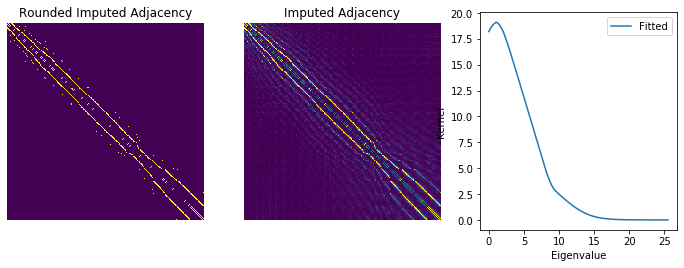

In [9]:
figlearn.plot()

We observe the learned filter is low-pass, which is what we expect since points that are near each other should have similar values. Looking at the resulting graph (below), we see that it mostly created edges between grid points that are close to each other. This demonstrates that our method can infer sensible graphs of medium size (397 nodes) in reasonable time. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


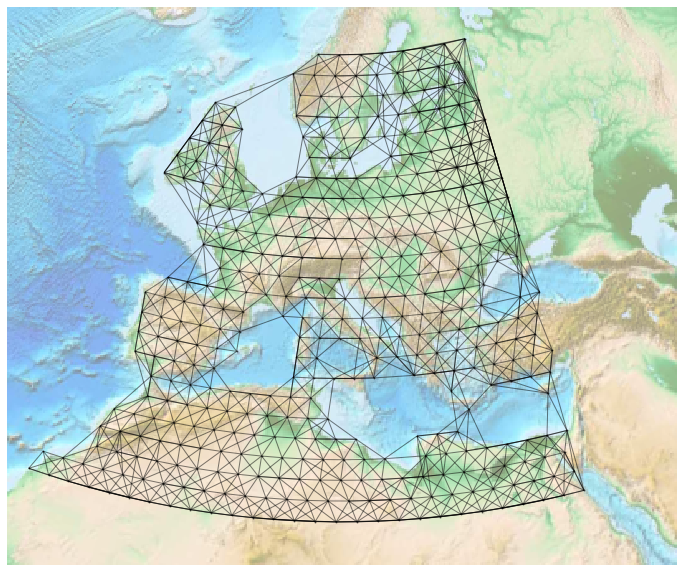

In [34]:
plt.figure(figsize=(12,12))
plot_graph(figlearn, 'k', node_size=1, alpha=.5, colorbar=False)
plt.savefig('../res/temperature_graph.png')

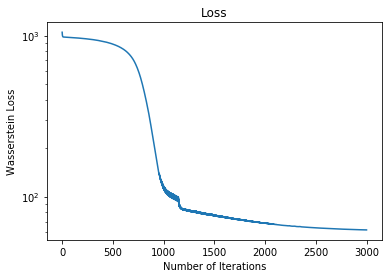

In [11]:
figlearn.plot_loss()

The curve of the loss suggests that we start off at a point in the optimization landscape that is flat. It is only after iteration 800 that we really get close to the objective. 

# Testing the Imputation
Having obtained a graph and a filter, we use this to impute missing values. For all signals of the test set, we only retain 10% of the values. All other values will be considered as missing. 

In [12]:
np.random.seed(3)
mask = np.random.uniform(size=temp_test.shape)>.9

We impute the missing values using the `impute_missing` function. If no mask is provided, all matrix entries with value `np.nan` are considered as missing, all others as present.

In [13]:
generating, imputed = figlearn.impute_missing(temp_test, mask)

In [28]:
def plot_three(ix):
    """Convenience function that plots the mask, the imputed and true values 
    for a given index of the test set"""

    vmin = min(imputed[ix].min(), temp_test[ix].min())
    vmax = max(imputed[ix].max(), temp_test[ix].max())

    plt.figure(figsize=(24,6))
    plt.subplot(131)
    plot_graph(figlearn, mask[ix], 'Greens', node_size=70)
    plt.title('Data Used for Imputed')
    plt.subplot(132)
    plot_graph(figlearn, imputed[ix], vmin=-3, vmax=3, node_size=70)
    plt.title('Imputed Signal')
    plt.subplot(133)
    plot_graph(figlearn, temp_test[ix], vmin=-3, vmax=3, node_size=70)
    plt.title('True Signal')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of nodes used: 50


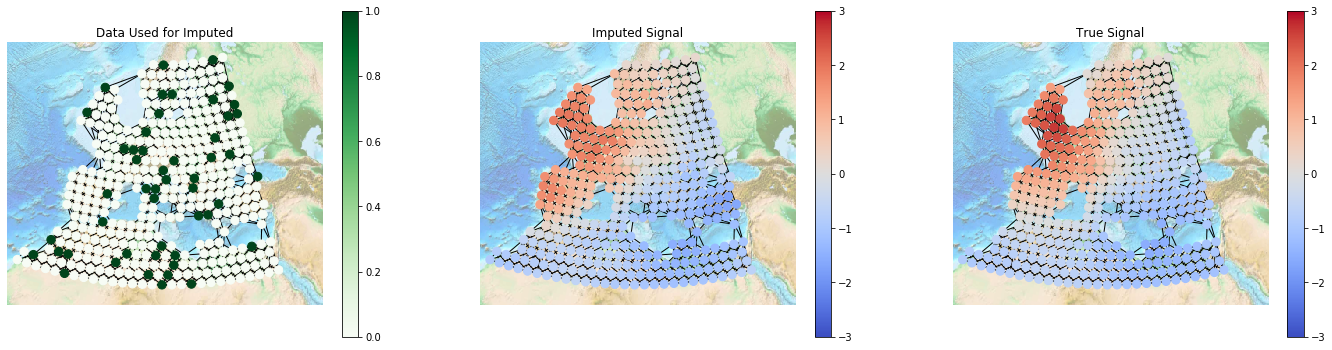

In [29]:
ix=3
plot_three(ix)
plt.savefig('../res/imp_good.svg')
print('Number of nodes used:', mask[ix].sum())

We observe that in this example, the method does extremely well. There are no major differences visible between the imputed signal and the true signal, although only 50/397 of all nodes are used.
<br>
<br>
Let's calculate the mean squared error of every imputation.

Mean MSE: 0.1947164160022208 Std MSE: 0.13690867662512032


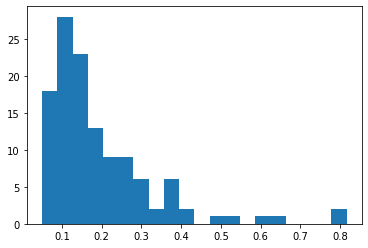

In [38]:
def mse(imputed, true, mask):
    inner = lambda x, y: ((x-y)**2).sum() / len(x)
    return np.array([inner(imputed[i,~m], true[i,~m]) for i, m in enumerate(mask)])

mse_te = mse(imputed, temp_test, mask)
print('Mean MSE:', mse_te.mean(), 'Std MSE:', mse_te.std())
plt.hist(mse_te, bins=20);

On average, we thus make a mistake of 0.2°C on data points for which we don't know the value. Looking at the distributions, there seem to be some cases on which we perform particularly bad. Let's look at what went wrong.

In [17]:
worst = np.argmax(mse_te)

In [41]:
mse_te[worst]

0.8163610170965325

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of nodes used: 50


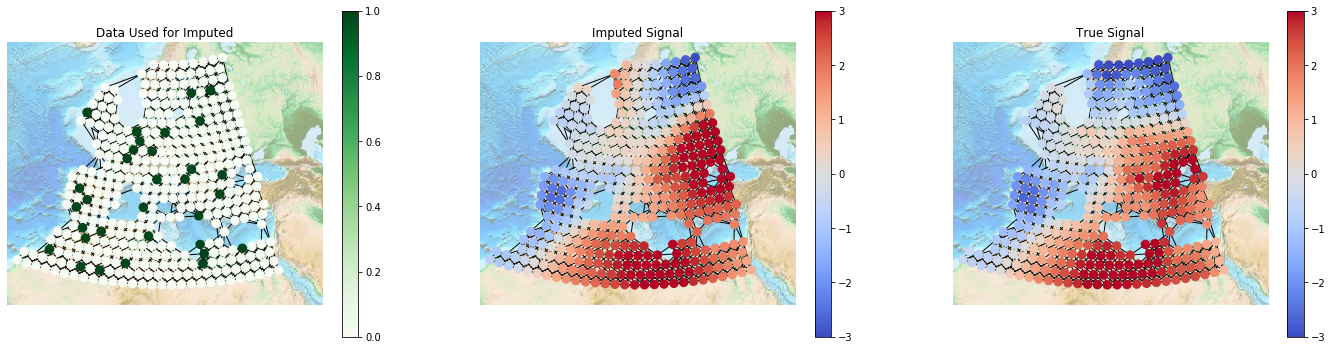

In [30]:
plot_three(worst)
plt.savefig('../res/imp_bad.svg')

print('Number of nodes used:', mask[ix].sum())

We see that in this (worst case) example, the method completely fails to capture the hot temperature on the coast of Norway. Note that it doesn't consider any nodes in that region, which is why it has no way to know that the temperatures are unusualy high there. It further fails north of the black sea, where again it has little information and thus overestimates the temperature.

# Imputing Missing Data
Having established that our missing data imputation method works well, we can apply it to the missing data in our data set. In particular we will consider the temperature anomaly in June 1750, for which 110 of the values are missing. We will impute the missing values with different seed in order to obtain error-bars.

In [19]:
jun1750 = temp[5,touse_xy]
np.isnan(jun1750).sum()

110

In [20]:
jun1750_imp = np.array([figlearn.impute_missing(jun1750, seed=i)[1] for i in range(50)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


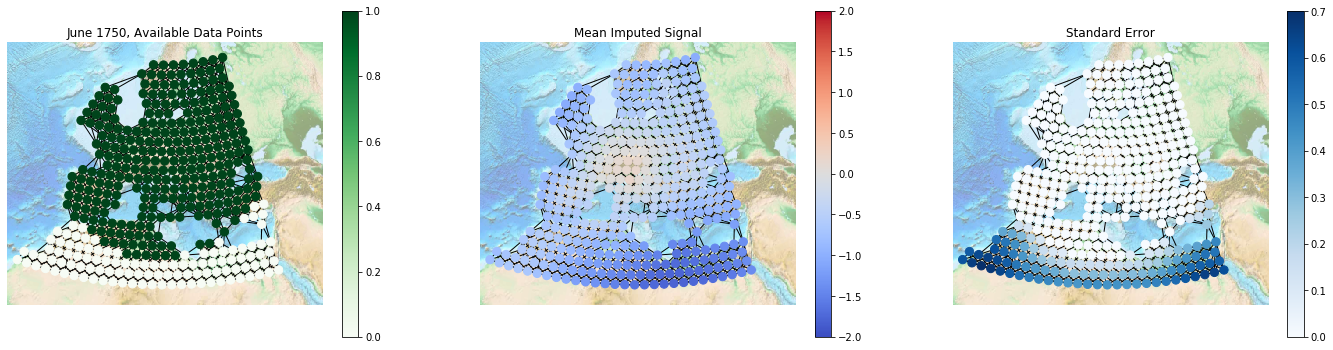

In [21]:
plt.figure(figsize=(24,6))
plt.subplot(131)
plot_graph(figlearn,(~np.isnan(jun1750)).astype(int), 'Greens', node_size=70)
plt.title('June 1750, Available Data Points'.format(time[is_nan][ix]))
plt.subplot(132)
plot_graph(figlearn, jun1750_imp.mean(axis=0), node_size=70, vmin=-2, vmax=2)
plt.title('Mean Imputed Signal')

plt.subplot(133)
plot_graph(figlearn, jun1750_imp.std(axis=0), 'Blues', node_size=70)
plt.title('Standard Error');


We observe that the standard error increases as we go further away from available information, as expected.